<a href="https://colab.research.google.com/github/akinivors/CENG543_Midterm_290201005/blob/main/Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- STEP 1: SETUP & DATA LOADING (Multi30k) ---
# Install necessary libraries (run once)
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install datasets

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# 1. Set Seed for Reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Load Tokenizers (Spacy)
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1] # Reverse source (standard trick for LSTM)

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# 3. Load Dataset (Bentrevett/multi30k)
# We use this HF mirror because the original torchtext link is often broken
print("Downloading Multi30k dataset...")
dataset = load_dataset("bentrevett/multi30k")

# 4. Build Vocabulary
def build_vocab(data_split, tokenizer, min_freq=2):
    counter = Counter()
    for item in data_split:
        counter.update(tokenizer(item))

    # Special tokens
    vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
    idx = 4
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

print("Building Vocabularies...")
src_vocab = build_vocab(dataset['train']['de'], tokenize_de)
trg_vocab = build_vocab(dataset['train']['en'], tokenize_en)

print(f"German (Source) Vocab Size: {len(src_vocab)}")
print(f"English (Target) Vocab Size: {len(trg_vocab)}")

# 5. Create DataLoaders
def collate_batch(batch):
    src_list, trg_list = [], []
    for item in batch:
        # Numericalize German
        src_tokens = [src_vocab.get(t, src_vocab['<unk>']) for t in tokenize_de(item['de'])]
        src_tensor = torch.tensor([src_vocab['<sos>']] + src_tokens + [src_vocab['<eos>']], dtype=torch.long)

        # Numericalize English
        trg_tokens = [trg_vocab.get(t, trg_vocab['<unk>']) for t in tokenize_en(item['en'])]
        trg_tensor = torch.tensor([trg_vocab['<sos>']] + trg_tokens + [trg_vocab['<eos>']], dtype=torch.long)

        src_list.append(src_tensor)
        trg_list.append(trg_tensor)

    # Pad sequences
    src_padded = pad_sequence(src_list, padding_value=src_vocab['<pad>'])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab['<pad>'])

    return src_padded, trg_padded

BATCH_SIZE = 128
train_iter = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_iter = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_iter = DataLoader(dataset['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("DataLoaders ready!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 120.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Building Vocabularies...
German (Source) Vocab Size: 8014
English (Target) Vocab Size: 6191
DataLoaders ready!


In [2]:
# --- STEP 2: MODEL ARCHITECTURE (Encoder-Decoder with Modular Attention) ---

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # Bidirectional GRU for better context
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        # Fully connected layer to map (fwd+bwd) hidden states to decoder hidden size
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))

        # outputs = [src len, batch size, hid dim * 2]
        # hidden = [2, batch size, hid dim]
        outputs, hidden = self.rnn(embedded)

        # Concatenate forward and backward hidden states
        # hidden[-2,:,:] is forward, hidden[-1,:,:] is backward
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, method):
        super().__init__()
        self.method = method
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        # 1. Additive (Bahdanau): v * tanh(W1*h_dec + W2*h_enc)
        if method == 'additive':
            self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
            self.v = nn.Linear(dec_hid_dim, 1, bias=False)

        # 2. Multiplicative (Luong): h_dec^T * W * h_enc
        elif method == 'multiplicative':
            self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        # 3. Scaled Dot-Product: (h_dec * h_enc) / sqrt(dim)
        # No learnable parameters needed for 'dot' if dimensions match
        # But we use a projection if dimensions differ
        elif method == 'dot':
            if (enc_hid_dim * 2) != dec_hid_dim:
                self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, dec hid dim]
        # encoder_outputs = [src len, batch size, enc hid dim * 2]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # Repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # encoder_outputs = [batch size, src len, enc hid dim * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # --- CALCULATE ENERGY SCORES ---
        if self.method == 'additive':
            energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
            attention = self.v(energy).squeeze(2)

        elif self.method == 'multiplicative':
            # Project encoder outputs to match decoder dimension
            projected_encoder = self.attn(encoder_outputs)
            # Dot product: [batch, src_len, dec_hid] * [batch, dec_hid, 1] -> [batch, src_len]
            attention = torch.bmm(projected_encoder, hidden.unsqueeze(2)).squeeze(2)

        elif self.method == 'dot':
            # Handle dimension mismatch if any
            if (self.enc_hid_dim * 2) != self.dec_hid_dim:
                encoder_outputs = self.attn(encoder_outputs)

            # Scaled Dot Product
            scale = torch.sqrt(torch.FloatTensor([self.dec_hid_dim])).to(hidden.device)
            attention = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
            attention = attention / scale

        # Return Softmax (Values between 0 and 1)
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size] (1 token at a time)
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        # Calculate Attention Weights
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src len]
        a = a.unsqueeze(1)

        # Weighted Sum of Encoder Outputs
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)

        # RNN Input: Embedding + Context Vector
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        # Prediction Input: Embedding + Hidden + Context Vector
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Encoder Forward
        encoder_outputs, hidden = self.encoder(src)

        # First input to decoder is <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            # Decoder Forward
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output

            # Teacher Forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

import torch.nn.functional as F
print("Model Architecture Defined (Encoder, Decoder, Attention, Seq2Seq).")

Model Architecture Defined (Encoder, Decoder, Attention, Seq2Seq).


In [4]:
# --- STEP 2.1: CORRECTED ATTENTION CLASS ---
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, method):
        super().__init__()
        self.method = method
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        # 1. Additive (Bahdanau): v * tanh(W1*h_dec + W2*h_enc)
        if method == 'additive':
            self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
            self.v = nn.Linear(dec_hid_dim, 1, bias=False)

        # 2. Multiplicative (Luong): h_dec^T * W * h_enc
        elif method == 'multiplicative':
            self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        # 3. Scaled Dot-Product: (h_dec * h_enc) / sqrt(dim)
        elif method == 'dot':
            if (enc_hid_dim * 2) != dec_hid_dim:
                self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, dec hid dim]
        # encoder_outputs = [src len, batch size, enc hid dim * 2]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # encoder_outputs = [batch size, src len, enc hid dim * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # --- CALCULATE ENERGY SCORES ---
        if self.method == 'additive':
            # EXPAND HIDDEN ONLY FOR ADDITIVE
            # hidden becomes [batch size, src len, dec hid dim]
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)

            energy = torch.tanh(self.attn(torch.cat((hidden_expanded, encoder_outputs), dim=2)))
            attention = self.v(energy).squeeze(2)

        elif self.method == 'multiplicative':
            # Project encoder outputs to match decoder dimension
            projected_encoder = self.attn(encoder_outputs)

            # Dot product: [batch, src_len, dec_hid] * [batch, dec_hid, 1] -> [batch, src_len]
            # We use the original un-expanded 'hidden' here
            attention = torch.bmm(projected_encoder, hidden.unsqueeze(2)).squeeze(2)

        elif self.method == 'dot':
            # Handle dimension mismatch if any
            if (self.enc_hid_dim * 2) != self.dec_hid_dim:
                encoder_outputs = self.attn(encoder_outputs)

            # Scaled Dot Product
            scale = torch.sqrt(torch.FloatTensor([self.dec_hid_dim])).to(hidden.device)
            attention = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
            attention = attention / scale

        # Return Softmax (Values between 0 and 1)
        return F.softmax(attention, dim=1)

print("Attention Class Updated. Please re-run the Training Loop now.")

Attention Class Updated. Please re-run the Training Loop now.


In [5]:
# --- STEP 3: TRAINING LOOP FOR ALL 3 ATTENTION MECHANISMS ---
import math
import time
from tqdm import tqdm

# 1. Initialize Weights (Xavier Uniform is standard for Seq2Seq)
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.xavier_uniform_(param.data)
        else:
            nn.init.constant_(param.data, 0)

# 2. Training Function
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)
        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# 3. Evaluation Function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0) # Turn off teacher forcing

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# --- MAIN EXECUTION LOOP ---
ATTENTION_METHODS = ['additive', 'multiplicative', 'dot']
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
# Hyperparameters
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 10
CLIP = 1

results = {}

print(f"Starting Training for {ATTENTION_METHODS}...")

for method in ATTENTION_METHODS:
    print(f"\n{'='*20}\nTraining Model with {method.upper()} Attention\n{'='*20}")

    # 1. Initialize Components
    attn = Attention(ENC_HID_DIM, DEC_HID_DIM, method)
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
    model = Seq2Seq(enc, dec, device).to(device)

    model.apply(init_weights)

    # 2. Optimizer & Loss
    optimizer = optim.Adam(model.parameters())
    TRG_PAD_IDX = trg_vocab['<pad>']
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

    best_valid_loss = float('inf')

    # 3. Training Loop
    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss = train(model, train_iter, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, valid_iter, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Save Best Model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'tut2_model_{method}.pt')

        # Calculate Perplexity (PPL = exp(loss))
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    results[method] = best_valid_loss

print("\nAll models trained successfully!")

Starting Training for ['additive', 'multiplicative', 'dot']...

Training Model with ADDITIVE Attention
Epoch: 01 | Time: 0m 31s
	Train Loss: 4.862 | Train PPL: 129.344
	 Val. Loss: 4.608 |  Val. PPL: 100.249
Epoch: 02 | Time: 0m 31s
	Train Loss: 3.799 | Train PPL:  44.654
	 Val. Loss: 3.835 |  Val. PPL:  46.286
Epoch: 03 | Time: 0m 31s
	Train Loss: 3.090 | Train PPL:  21.968
	 Val. Loss: 3.502 |  Val. PPL:  33.173
Epoch: 04 | Time: 0m 31s
	Train Loss: 2.630 | Train PPL:  13.881
	 Val. Loss: 3.273 |  Val. PPL:  26.386
Epoch: 05 | Time: 0m 31s
	Train Loss: 2.312 | Train PPL:  10.097
	 Val. Loss: 3.239 |  Val. PPL:  25.500
Epoch: 06 | Time: 0m 31s
	Train Loss: 2.063 | Train PPL:   7.873
	 Val. Loss: 3.242 |  Val. PPL:  25.593
Epoch: 07 | Time: 0m 32s
	Train Loss: 1.814 | Train PPL:   6.137
	 Val. Loss: 3.223 |  Val. PPL:  25.100
Epoch: 08 | Time: 0m 32s
	Train Loss: 1.645 | Train PPL:   5.181
	 Val. Loss: 3.323 |  Val. PPL:  27.745
Epoch: 09 | Time: 0m 32s
	Train Loss: 1.498 | Train PPL: 

Selected Fixed Test Indices for Visualization: [654, 114, 25, 759, 281]

========== Evaluating tut2_model_additive.pt ==========
Calculating BLEU/ROUGE (generating translations)...


100%|██████████| 1000/1000 [00:14<00:00, 71.24it/s]



Results for ADDITIVE:
Test PPL: 26.301
BLEU: 0.2514
ROUGE-1: 0.6320
ROUGE-L: 0.6142

--- Visualizing Fixed Samples (ADDITIVE) ---

Sample 1 (ID: 654):
Source: Zwei junge Männer fahren auf einem sehr kleinen Wagen voller Kartoffeln, der von einem Pferd gezogen wird.
Target: Two young men riding on a very small horse-drawn wagon full of potatoes.
Pred (additive): Two young men riding a very very small cart filled with a horse .


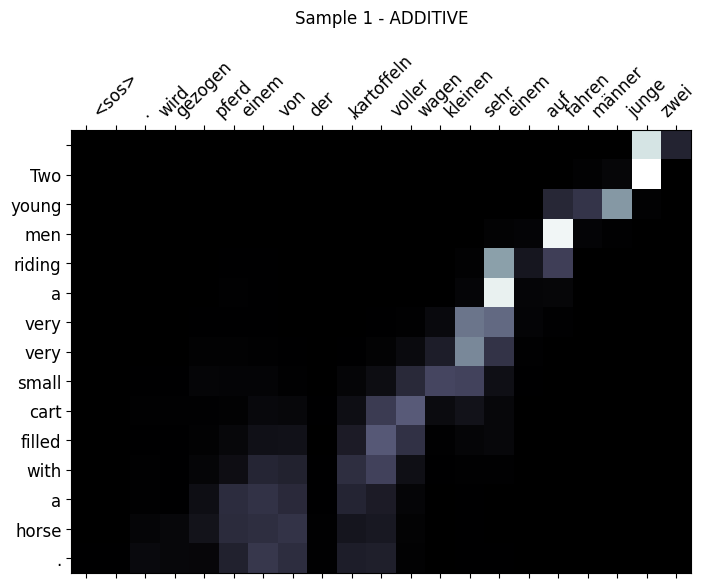


Sample 2 (ID: 114):
Source: Zwei indische Männer nehmen an einer Zeremonie teil.
Target: Two Indian men participating in a ceremony.
Pred (additive): Two Indian men taking a ceremony .


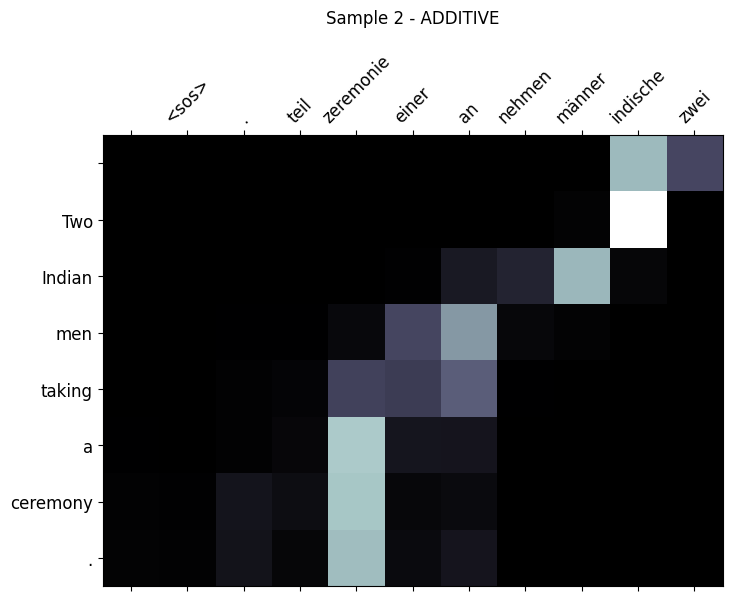


Sample 3 (ID: 25):
Source: Eine Frau in einem pinken Pulli und einer Schürze putzt einen Tisch mit einem Schwamm.
Target: A woman in a pink sweater and an apron, cleaning a table with a sponge.
Pred (additive): A woman in a pink sweatshirt and apron apron is a a table with a a .


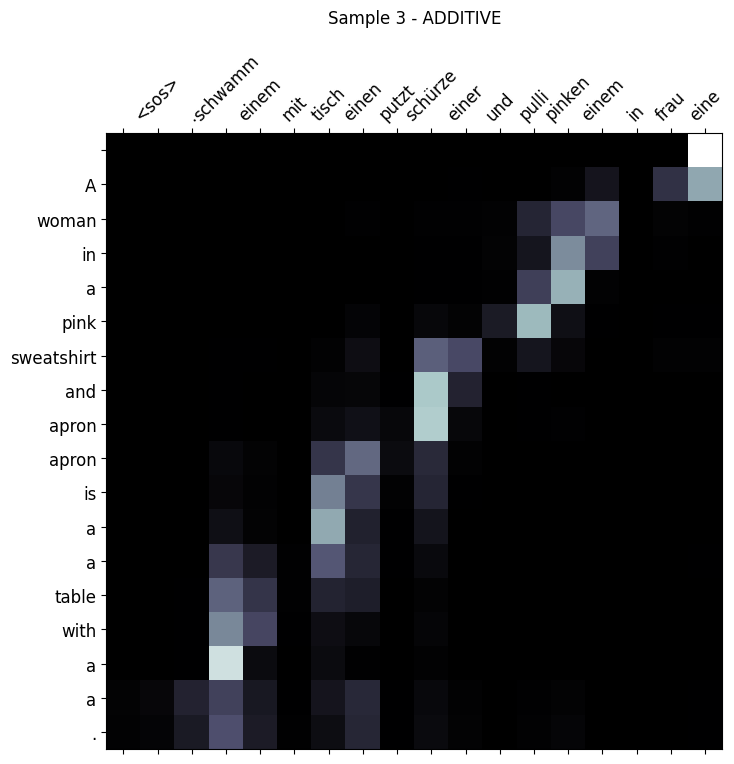


Sample 4 (ID: 759):
Source: Ein lächelnder Mann mit Rucksack streckt vor einem Jungen mit Brille die Fäuste in die Luft.
Target: A smiling man wearing a backpack holds his fists up in front of a boy in glasses.
Pred (additive): A smiling man with a backpack is skateboarding in front of a boy with glasses in in the air .


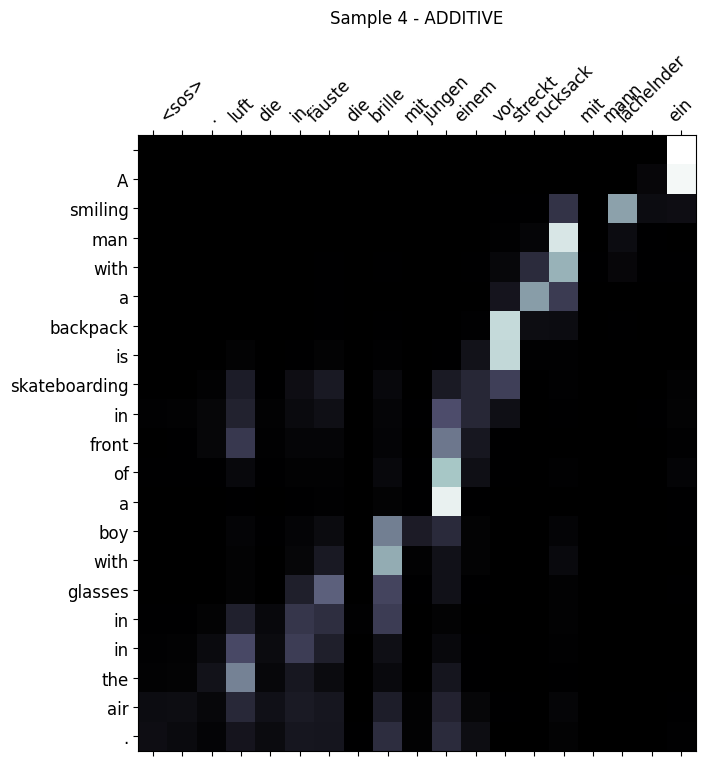


Sample 5 (ID: 281):
Source: Ein Hund springt um einen Ball zu fangen, während ein anderer zusieht.
Target: One dog leaps to catch a softball while another looks on.
Pred (additive): A dog is to catch a ball while another watches .


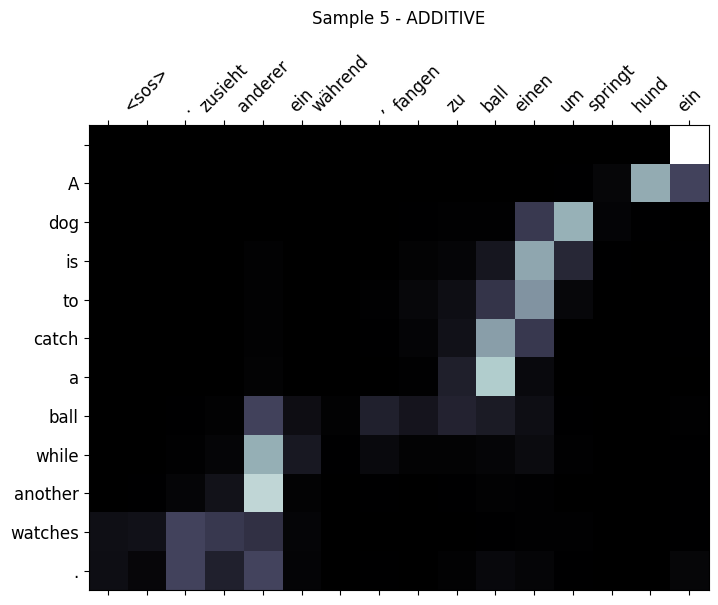


========== Evaluating tut2_model_multiplicative.pt ==========
Calculating BLEU/ROUGE (generating translations)...


100%|██████████| 1000/1000 [00:12<00:00, 79.29it/s]



Results for MULTIPLICATIVE:
Test PPL: 29.351
BLEU: 0.2180
ROUGE-1: 0.5934
ROUGE-L: 0.5760

--- Visualizing Fixed Samples (MULTIPLICATIVE) ---

Sample 1 (ID: 654):
Source: Zwei junge Männer fahren auf einem sehr kleinen Wagen voller Kartoffeln, der von einem Pferd gezogen wird.
Target: Two young men riding on a very small horse-drawn wagon full of potatoes.
Pred (multiplicative): Two young men are on a very small wagon with a horse pulled by a horse .


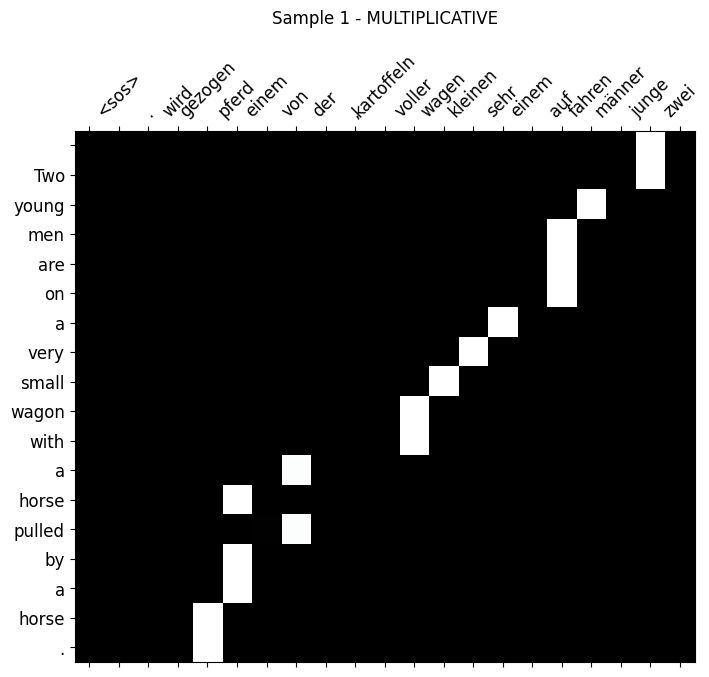


Sample 2 (ID: 114):
Source: Zwei indische Männer nehmen an einer Zeremonie teil.
Target: Two Indian men participating in a ceremony.
Pred (multiplicative): Two Indian men are in a a ceremony .


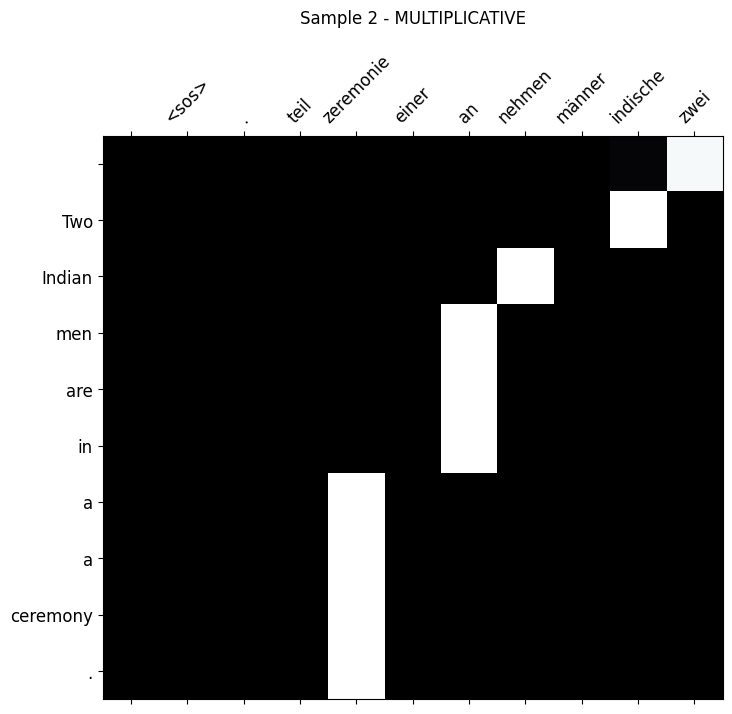


Sample 3 (ID: 25):
Source: Eine Frau in einem pinken Pulli und einer Schürze putzt einen Tisch mit einem Schwamm.
Target: A woman in a pink sweater and an apron, cleaning a table with a sponge.
Pred (multiplicative): A woman in a pink sweater and a apron is a a table with a man .


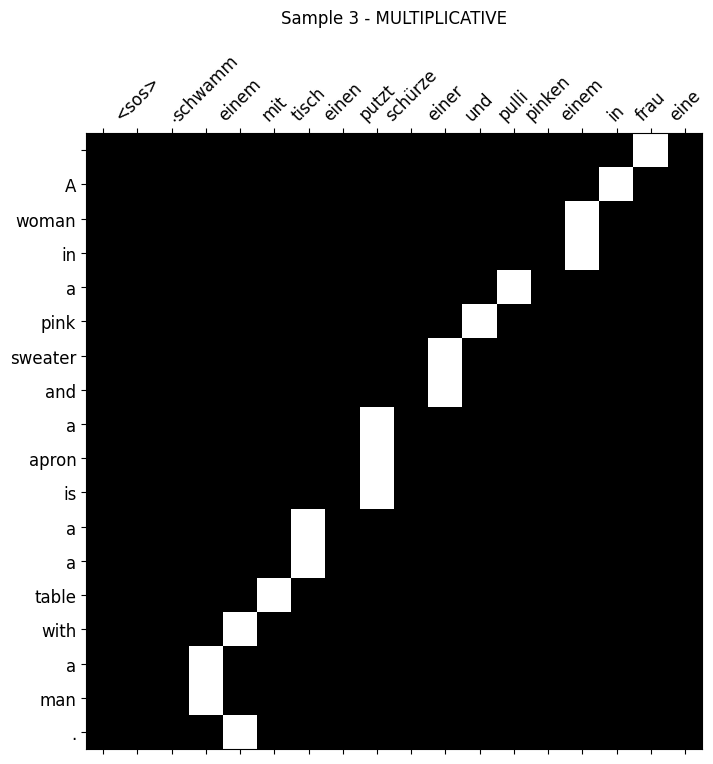


Sample 4 (ID: 759):
Source: Ein lächelnder Mann mit Rucksack streckt vor einem Jungen mit Brille die Fäuste in die Luft.
Target: A smiling man wearing a backpack holds his fists up in front of a boy in glasses.
Pred (multiplicative): A smiling man with a backpack is his face with with his arms up in the air .


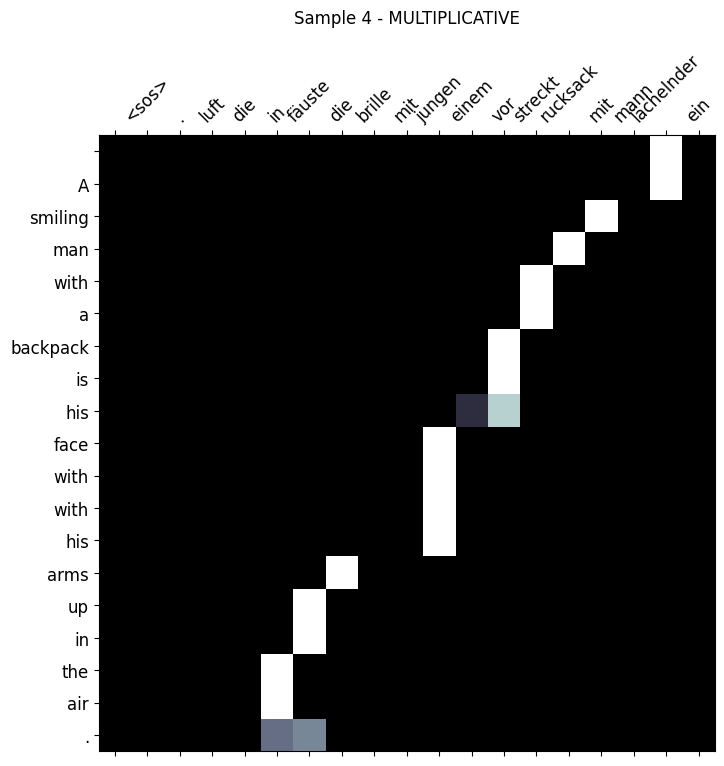


Sample 5 (ID: 281):
Source: Ein Hund springt um einen Ball zu fangen, während ein anderer zusieht.
Target: One dog leaps to catch a softball while another looks on.
Pred (multiplicative): A dog is jumping to catch a ball ball while another watches watches .


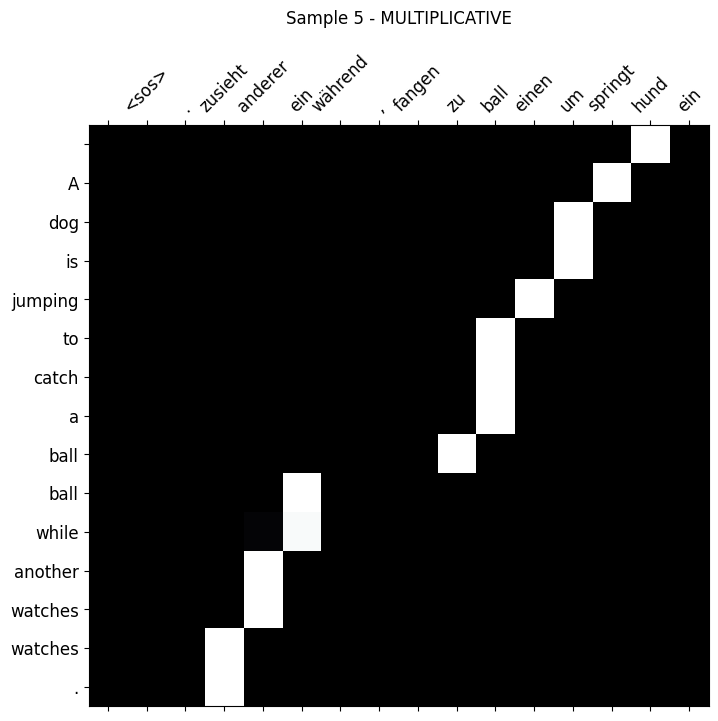


========== Evaluating tut2_model_dot.pt ==========
Calculating BLEU/ROUGE (generating translations)...


100%|██████████| 1000/1000 [00:14<00:00, 70.52it/s]



Results for DOT:
Test PPL: 26.165
BLEU: 0.2504
ROUGE-1: 0.6245
ROUGE-L: 0.6060

--- Visualizing Fixed Samples (DOT) ---

Sample 1 (ID: 654):
Source: Zwei junge Männer fahren auf einem sehr kleinen Wagen voller Kartoffeln, der von einem Pferd gezogen wird.
Target: Two young men riding on a very small horse-drawn wagon full of potatoes.
Pred (dot): Two young men are riding a small small cart with a <unk> with a horse pulled by a horse .


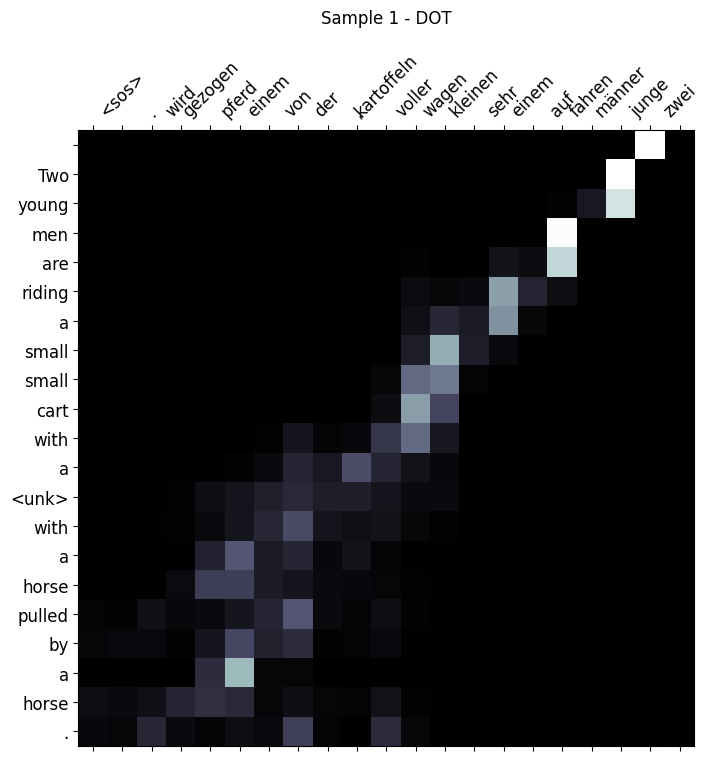


Sample 2 (ID: 114):
Source: Zwei indische Männer nehmen an einer Zeremonie teil.
Target: Two Indian men participating in a ceremony.
Pred (dot): Two Indian men participate in a ceremony .


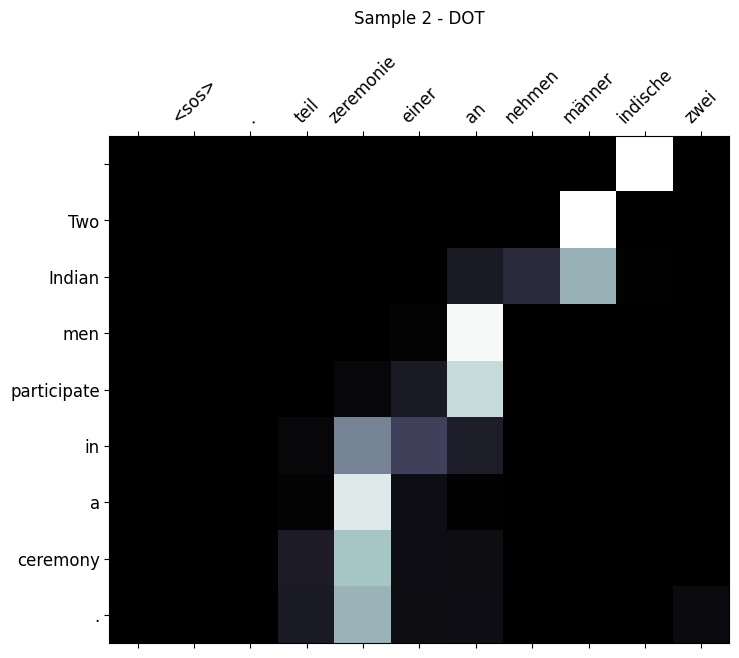


Sample 3 (ID: 25):
Source: Eine Frau in einem pinken Pulli und einer Schürze putzt einen Tisch mit einem Schwamm.
Target: A woman in a pink sweater and an apron, cleaning a table with a sponge.
Pred (dot): A woman in a pink sweater and an apron is a a table with a pot .


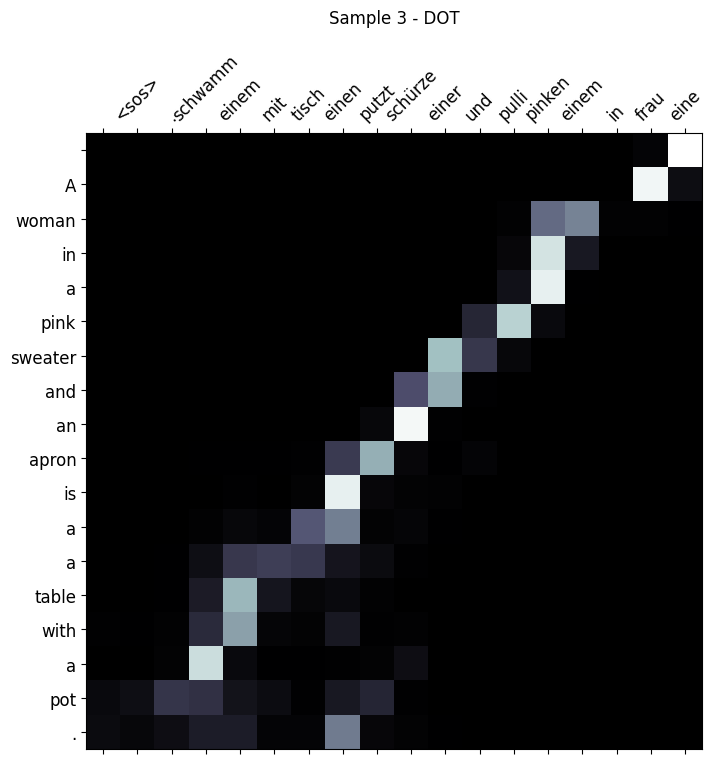


Sample 4 (ID: 759):
Source: Ein lächelnder Mann mit Rucksack streckt vor einem Jungen mit Brille die Fäuste in die Luft.
Target: A smiling man wearing a backpack holds his fists up in front of a boy in glasses.
Pred (dot): A smiling man wearing a backpack in front of a boy in his hands in the air .


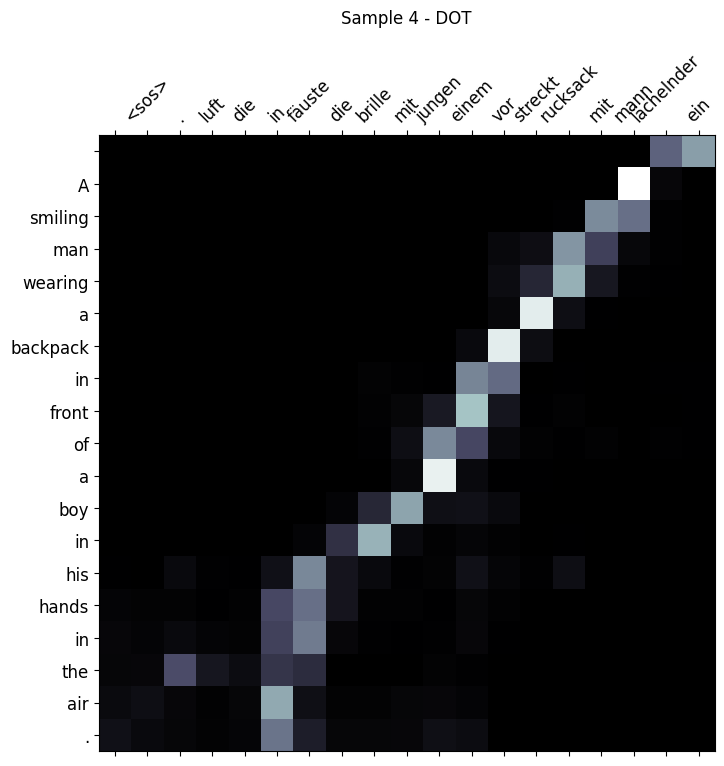


Sample 5 (ID: 281):
Source: Ein Hund springt um einen Ball zu fangen, während ein anderer zusieht.
Target: One dog leaps to catch a softball while another looks on.
Pred (dot): A dog jumps to catch a ball while another watches .


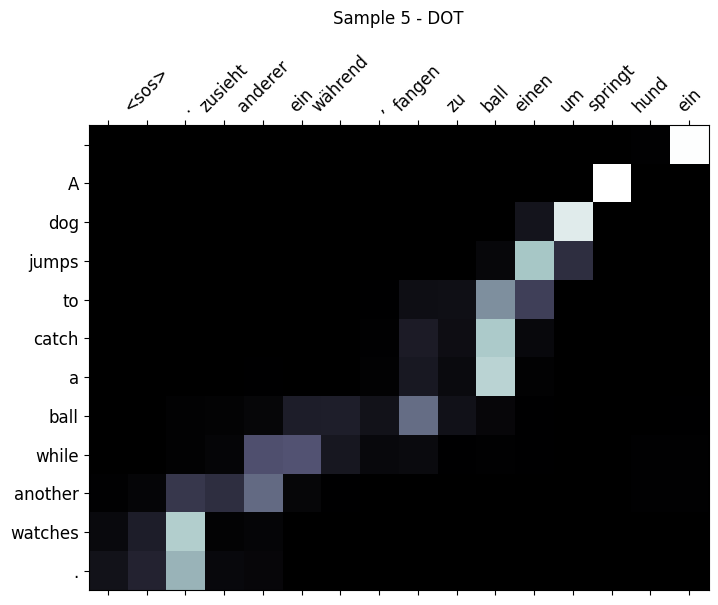

In [8]:
# --- STEP 4: EVALUATION & COMPARATIVE VISUALIZATION (All Models, Same Sentences) ---
# Install metrics library if needed
# !pip install torchmetrics

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torchmetrics.text import BLEUScore, ROUGEScore
import random

# 1. Select 5 Fixed Indices for Fair Comparison
# We pick them once so every model translates the EXACT same sentences
raw_test_data = dataset['test']
# You can change the seed to get different sentences if you don't like these
random.seed(42)
FIXED_INDICES = random.sample(range(len(raw_test_data)), 5)
print(f"Selected Fixed Test Indices for Visualization: {FIXED_INDICES}")

# 2. Translation Function
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        tokens = [token.text for token in spacy_de.tokenizer(sentence)]
    else:
        tokens = sentence

    tokens = [src_vocab.get(t, src_vocab['<unk>']) for t in tokens]
    tokens = [src_vocab['<sos>']] + tokens + [src_vocab['<eos>']]

    src_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [trg_vocab['<sos>']]
    attentions = torch.zeros(max_len, 1, len(tokens)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break

    trg_tokens = []
    idx_to_trg = {v: k for k, v in trg_vocab.items()}

    for i in trg_indexes:
        trg_tokens.append(idx_to_trg[i])

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

# 3. Display Attention Heatmap
def display_attention(sentence, translation, attention, title=None):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=12)

    # Set ticks
    # We use FixedLocator to avoid warnings
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(['<sos>'] + sentence + ['<eos>']) + 1)))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(translation) + 1)))

    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
    ax.set_yticklabels([''] + translation)

    if title:
        plt.title(title, pad=20)
    plt.show()

# 4. Evaluation Loop
def calculate_metrics_and_visualize(model_name, test_iterator, src_vocab, trg_vocab):
    print(f"\n{'='*10} Evaluating {model_name} {'='*10}")
    attn_type = model_name.split('_')[-1].replace('.pt', '')

    # Re-init model
    attn = Attention(ENC_HID_DIM, DEC_HID_DIM, attn_type)
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
    model = Seq2Seq(enc, dec, device).to(device)

    # Load Weights
    model.load_state_dict(torch.load(model_name, map_location=device))

    # --- METRICS ---
    bleu = BLEUScore()
    rouge = ROUGEScore()
    preds, targets = [], []

    # Calculate PPL
    criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab['<pad>'])
    test_loss = evaluate(model, test_iterator, criterion)
    test_ppl = math.exp(test_loss)

    # Generate all translations for BLEU
    # (Comment this loop out if you ONLY want visualization and want to save time)
    print("Calculating BLEU/ROUGE (generating translations)...")
    for i in tqdm(range(len(raw_test_data))):
        src = raw_test_data[i]['de']
        trg = raw_test_data[i]['en']
        src_tokens = tokenize_de(src)
        pred_tokens, _ = translate_sentence(src_tokens, src_vocab, trg_vocab, model, device)
        preds.append(" ".join(pred_tokens[:-1]))
        targets.append(trg)

    b_score = bleu(preds, [[t] for t in targets])
    r_score = rouge(preds, targets)

    print(f"\nResults for {attn_type.upper()}:")
    print(f"Test PPL: {test_ppl:.3f}")
    print(f"BLEU: {b_score.item():.4f}")
    print(f"ROUGE-1: {r_score['rouge1_fmeasure'].item():.4f}")
    print(f"ROUGE-L: {r_score['rougeL_fmeasure'].item():.4f}")

    # --- VISUALIZATION (Fixed Indices) ---
    print(f"\n--- Visualizing Fixed Samples ({attn_type.upper()}) ---")
    for i, idx in enumerate(FIXED_INDICES):
        src = raw_test_data[idx]['de']
        trg = raw_test_data[idx]['en']

        src_tokens = tokenize_de(src)
        pred_tokens, attention = translate_sentence(src_tokens, src_vocab, trg_vocab, model, device)

        print(f"\nSample {i+1} (ID: {idx}):")
        print(f"Source: {src}")
        print(f"Target: {trg}")
        print(f"Pred ({attn_type}): {' '.join(pred_tokens[:-1])}")

        display_attention(src_tokens, pred_tokens, attention, title=f"Sample {i+1} - {attn_type.upper()}")

# --- RUN ALL ---
for method in ['additive', 'multiplicative', 'dot']:
    calculate_metrics_and_visualize(f'tut2_model_{method}.pt', test_iter, src_vocab, trg_vocab)